# Solution to Depletion Drive Reservoir using Tarner's Method


## Introdution 
------------
<font size =3.5>This project is targeted to calculate the future performance of a depletion drive reservoir system using a computer program that can reduce the time of computation and also give more in-depth analysis at one go. This notebook is the demonstration of the project and the steps of solving for depletion drive using Tarner's Method. Tarner's Method is based on the MBE trial and error technique that uses an iterative method to approximate the cumulative oil production at each required pressure stages of depletion.</font>

### Algorithm Flow diagram
![Img]()

### Python for caluation
-----------------

Importing Useful libraries for calculation

In [1]:
#Important Imports
import numpy as np 
from scipy.optimize import curve_fit  
from matplotlib import pyplot as plt
from matplotlib import ticker  

%matplotlib inline

## Sample Reservoir Data
-----------------------
Avg. Depht = 6500<br>
Original Reservoir Pressure = 2925 psia<br>
Reservoir Saturation Pressure = 2100 psia<br>
Reservoir temperature = 175 °F<br>
Initial Water Saturation = 15%<br>
Original Oil in place N = 100,000,000 STB (from geologic data)<br>
--No gas cap<br>
-- NO Water Drive<br>
Specific Gravity of gas = 0.7<br>

### Table 1
---------------------
<table width="80%"> 
    <tr>
        <th>Pressure</th>
        <th>Z</th>
        <th>R<sub>s</sub></th>
        <th>B<sub>o</sub></th>
        <th>µ<sub>o</sub>/µ<sub>g</sub></th>
    </tr>
    <tr>
        <td>2100</td>
        <td>0.842</td>
        <td>1340</td>
        <td>1.480</td>
        <td>34.1</td>
    </tr>
    <tr>
        <td>1800</td>
        <td>0.854</td>
        <td>1280</td>
        <td>1.468</td>
        <td>38.3</td>
    </tr>
    <tr>
        <td>1500</td>
        <td>0.869</td>
        <td>1500</td>
        <td>1.440</td>
        <td>42.4</td>
    </tr>
    <tr>
        <td>1200</td>
        <td>0.888</td>
        <td>985</td>
        <td>1.399</td>
        <td>48.8</td>
    </tr>
    <tr>
        <td>1000</td>
        <td>0.901</td>
        <td>860</td>
        <td>1.360</td>
        <td>53.6</td>
    </tr>
    <tr>
        <td>700</td>
        <td>0.929</td>
        <td>662</td>
        <td>1.287</td>
        <td>62.5</td>
    </tr>
    <tr>
        <td>400</td>
        <td>0.960</td>
        <td>465</td>
        <td>1.202</td>
        <td>79.0</td>
    </tr>
</table>

In [2]:
# Data variable
Pressure = np.asarray([2100,1800,1500,1200,1000,700,400])
Rs = np.asarray([1340,1280,1150,985,860,662,465])
Bo = np.asarray([1.48,1.468,1.440,1.399,1.360,1.287,1.202])
vis_ratio = np.asarray([34.1,38.3,42.4,48.8,53.6,62.5,79.0])
Z = np.asarray([0.842,0.854,0.869,0.888,0.901,0.929,0.960])

## Calculation of Bg and Bt
------------
#### Calculation of B<sub>g</sub> :
B<sub>g</sub> = (P<sub>s</sub>V<sub>s</sub>)ZT<sub>p</sub> / (PZ<sub>s</sub>T<sub>s</sub>x5.615)
<br>
#### Calculation of B<sub>t</sub> :
B<sub>t</sub> = B<sub>o</sub> + B<sub>g</sub> (R<sub>si</sub> - R<sub>s</sub>)

In [11]:
# Function to calculate Bg
def cal_Bg(Z , P):
    return (14.7*1*Z*(460+175))/(Pressure*1*520*5.615)

# Function to calculate Bt
def cal_Bt(Bo, Bg, Rsi, Rs):
    return Bo + (Rsi - Rs)* Bg

In [4]:
# Calculation Of Bt
Bg = cal_Bg(Z , Pressure)
Bt = cal_Bt(Bo, Bg, Rs[0], Rs)
Bt, Bg

(array([1.48      , 1.55900695, 1.79190065, 2.23884285, 2.74262366,
        4.16363873, 7.91562765]),
 array([0.00128183, 0.00151678, 0.00185211, 0.00236575, 0.00288047,
        0.00424283, 0.00767272]))

## Calculation at Different Pressure
------------
### Formulas:
<b>
* G<sub>mbl</sub> = N<sub>p1</sub> R<sub>p1</sub> = (N(B<sub>t</sub> - B<sub>ts</sub>) - N<sub>p</sub> (B<sub>t</sub>- R<sub>ss</sub> B<sub>g</sub>)) / B<sub>g</sub>
<br>

* S<sub>o</sub> = (1 - N<sub>p</sub>/N) (B<sub>o</sub>/B<sub>os</sub>) (1 - S<sub>wi</sub>) </b>

Using this S<sub>o</sub> and the equation formed using curve fitting (Kg.Ko vs So Plot.ipynb) can be used to calculate
<b>K<sub>g</sub>/K<sub>o</sub></b>.
<img src="Kg_KovsSo.png" width=70%><br>
* A least square fit is used for curve fitting. equivalent equation for K<sub>g</sub>/K<sub>o</sub> is as follows: 
<br><b>K<sub>g</sub>/K<sub>o</sub> = e<sup>f(S<sub>o</sub>)</sup></b>. <br><br>
*where:* <br> <b>f(S<sub>o</sub>) = 31.457 - 1.781 * S<sub>o</sub> + 0.041 * S<sub>o</sub><sup>2</sup> - 0.00044 * S<sub>o</sub><sup>3</sup> + 1.633 * S<sub>o</sub><sup>4</sup>  </b>


* <b>R<sub>1</sub> = (K<sub>g</sub>/K<sub>o</sub>) (µ<sub>o</sub>/µ<sub>g</sub>) (B<sub>o</sub>/B<sub>g</sub>) + R<sub>s</sub></b>

* <b>G<sub>gor1</sub> = 0.5 \*(R<sub>1</sub>+ R<sub>ss</sub>) N<sub>p1</sub>

In [23]:
# Coefficients of f(so)
coeff = [ -2.17631817e+01,  1.93353134e+00, -5.39629422e-02,  6.26273665e-04,-2.73300444e-06]

In [24]:
# Function to calculate Gmb
def cal_gmb(Np, Bt, Bti, Bg, Rss,CGppp):
    """
    Np   : Assumed Np/N ratio
    Bt   : Bt at Required Presure
    Bti  : Bt at Initial Pressure Reservoir Pressure
    Bg   : Bg at required Pressure
    Rss  : Initial GOR 
    CGppp: Cumulative Gas Production upto perivious pressure stage
    
    Return:
    Gmb : 
    """
    return (((Bt-Bti)- Np*(Bt - Rss*Bg))/ Bg ) - CGppp 

# Function to calculate So
def cal_so(Np, Bo, Boi, Swi):
    return (1- Np)*(Bo/Boi)*(1-Swi)

# Function to calculate Kg/Ko
def cal_kg_ko(So, *params):
    n =0
    r = np.zeros(So.shape)
    for param in params:
            r = r + param*np.power(So,n)
            n = n + 1
    return np.exp(r)

# Function to calculate R
def cal_R(kg_ko, vis_ratio, Bo, Bg, Rs):
    return kg_ko*vis_ratio*(Bo/Bg)+ Rs

# Function to calculate Ggor
def cal_Ggor(Np, Rp, R, CNppp):
    return 0.5 * (Rp + R) * (Np-CNppp)
    
# # Function to calculate Gmb1 and Ggor1
# def cal_trail(Np,Bo,Boi,Bt,Bti,Bg,Rs,Rss,Rp,vis_ratio,CGppp,CNppp, Swi,K_coeff):
#     Gmb = cal_gmb(Np , Bt, Bti, Bg, Rss,CGppp)
#     So = cal_so(Np,Bo,Boi,Swi)
#     K_ratio = cal_kg_ko(So, *K_coeff)
#     R = cal_R(K_ratio, vis_ratio, Bo,Bg,Rs)
#     Ggor = cal_Ggor(Np,Rp,R,CNppp)
    
#     return Gmb, Ggor, Gmb-Ggor

In [83]:
# Function to calculate Gmb1 and Ggor1
def cal_trail(Np,Bo,Boi,Bt,Bti,Bg,Rs,Rss,Rp,vis_ratio,CGppp,CNppp, Swi,K_coeff):
    Gmb = cal_gmb(Np , Bt, Bti, Bg, Rss,CGppp)
    So = cal_so(Np,Bo,Boi,Swi)
    K_ratio = cal_kg_ko(So, *K_coeff)
    R = cal_R(K_ratio, vis_ratio, Bo,Bg,Rs)
    Ggor = cal_Ggor(Np,Rp,R,CNppp)
    
    return Gmb, Ggor, Gmb-Ggor

In [79]:
Np_list = [0.01,0.03,0.04]
data = [cal_trail(Np, Bo[1],Bo[0], Bt[1],Bt[0],Bg[1], Rs[1], Rs[0], vis_ratio[1], 0.15, coeff) for Np in Np_list ]
print(data)
data = np.asarray(data)
data

[[55.210135099790385, 15.013999857940872, 40.19613524184951], [61.4533722260964, 47.7344198823413, 13.718952343755099], [64.5749907892494, 66.01978333437343, -1.4447925451240309]]


array([[55.2101351 , 15.01399986, 40.19613524],
       [61.45337223, 47.73441988, 13.71895234],
       [64.57499079, 66.01978333, -1.44479255]])

In [26]:
#starting Np
def solve_for_Np(Np_cal,Gp_cal,Rp_cal, Bo, Bg, Bt, Rs, vis_ratio,K_coeff, Swi = 0.15, delta = 0.01,index = 1, Np = 0.01):
    Bti = Bt[0]
    Boi = Bo[0]
    Rss = Rs[0]
    
    CGppp = np.sum(Gp_cal[:index])
    CNppp = Np_cal[index-1]
    
    Rp = Rp_cal[index-1]
    
#     print(CGppp)
    
    curr_Gmb, curr_Gogr, prev_diff= cal_trail(Np, Bo[index],Boi, Bt[index],Bti,Bg[index], Rs[index], Rss, Rp,
                                               vis_ratio[index],CGppp,CNppp, 0.15, K_coeff)
    print(curr_Gmb, curr_Gogr)
    sign_change = False
    curr_diff = prev_diff
    l_Np = Np
    r_Np = Np
    while abs(curr_diff) > 0.00001:
#         print(curr_diff,"  ",Np)
        if(sign_change == False):
            if(curr_diff > 0):
                Np = Np + delta
            else:
                Np = Np - delta
        else:
            Np = (l_Np + r_Np)*0.5 
        curr_Gmb, curr_Gogr, curr_diff = cal_trail(Np, Bo[index],Boi, Bt[index],Bti,Bg[index], Rs[index],Rss, Rp,
                                               vis_ratio[index],CGppp,CNppp, 0.15, K_coeff)
        if(curr_diff * prev_diff < 0 ) :
            sign_change = True
        elif sign_change == False:
            l_Np = Np
            r_Np = Np
        if(sign_change == True):
            if(curr_diff > 0):
                l_Np = Np
            elif(curr_diff < 0):
                r_Np = Np
        prev_diff = curr_diff
        
    return curr_Gmb , Np , (curr_Gmb/(Np-CNppp) * 2) - Rp_cal[index-1]
# solve_for_Np( Bo, Bg, Bt, Rs, vis_ratio, coeff,Swi = 0.15 )  

In [220]:
Gp_cal = np.zeros(7)
Np_cal = np.zeros(7)
Rp_cal = np.zeros(7)
Rp_cal[0] = Rs[0]
Gp_cal[1] , Np_cal[1], Rp_cal[1] = solve_for_Np(Np_cal,Gp_cal,Rp_cal,Bo, Bg, Bt, Rs, vis_ratio, coeff, Swi = 0.15 , index = 1)
Gp_cal[2] , Np_cal[2], Rp_cal[2] = solve_for_Np(Np_cal,Gp_cal,Rp_cal,Bo, Bg, Bt, Rs, vis_ratio, coeff, Swi = 0.15 , index = 2,Np = 0.05)
# Rp_cal[2] = 3584
Gp_cal[3] , Np_cal[3], Rp_cal[3] = solve_for_Np(Np_cal,Gp_cal,Rp_cal,Bo, Bg, Bt, Rs, vis_ratio, coeff, Swi = 0.15 , index = 3,Np = 0.12)
solve_for_Np(Np_cal,Gp_cal,Rp_cal,Bo, Bg, Bt, Rs, vis_ratio, coeff, Swi = 0.15 , index = 4,Np = 0.14)

55.210135099790385 15.013999857940872
122.7369507063949 22.529509400141162
165.50091485486354 127.34188779689549
121.86185866895767 95.46382483771447


(123.16463241278507, 0.14335892677307127, 8962.567159122864)

In [214]:
Rp_cal

array([1340.        , 1949.26746143, 3584.        ,    0.        ,
          0.        ,    0.        ,    0.        ])

In [215]:
Gp_cal , Np_cal

(array([  0.        ,  64.29143678, 138.20653827,   0.        ,
          0.        ,   0.        ,   0.        ]),
 array([0.        , 0.03909164, 0.09152822, 0.        , 0.        ,
        0.        , 0.        ]))

In [61]:
#Curve Fitting Function
def curve_fit_function(x, *params):
    n =0
    r = np.zeros(x.shape)
    for param in params:
            r = r + param*np.power(x,n)
            n = n + 1
    return r

In [63]:
# Degree Of Polyinomial
degree = 3
# Initialisizing array with shape [1, degree]
p = np.ones([1,degree])

# Curve Fitting
param, param_cov = curve_fit(curve_fit_function, Np_list, data[:,1:].reshape([1,3])[0], p0 = p) 
param

D:\Program\lib\site-packages\scipy\optimize\minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


array([5.78943286e-01, 1.37933388e+03, 6.41717813e+03])

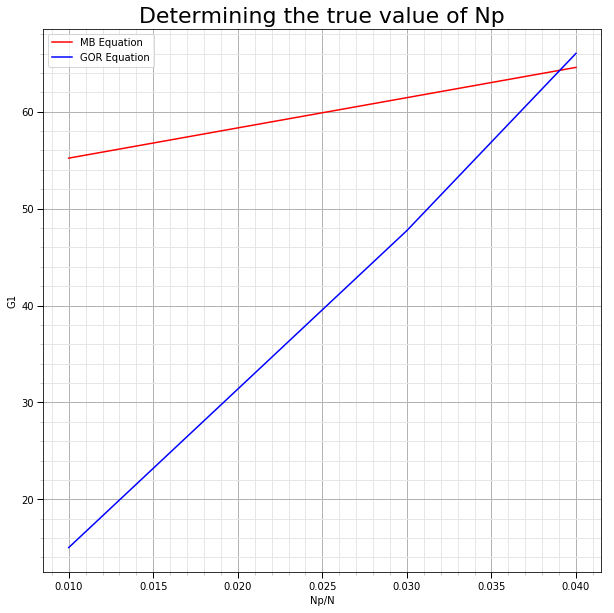

In [77]:
# Defining Matplotlib Figure
f = plt.figure(num=None, figsize=(10,10))

# Sub plot
ax = f.add_subplot(111)

plt.plot(Np_list , data[:,0:1] , c = 'r' , label = 'MB Equation')
plt.plot(Np_list , data[:,1:] , c = 'b', label = 'GOR Equation')

# a = np.argwhere(np.diff(np.sign(data[:,0:1].reshape([1,3])[0] - data[:,1:].reshape([1,3])[0]))).flatten()
# plt.plot(Np_list[a], data[:,0:1][a], 'ro')

# Tick-Parameters
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')

# Grid
plt.grid(lw = 1, ls = '-', c = "0.7", which = 'major')
plt.grid(lw = 1, ls = '-', c = "0.9", which = 'minor')

# Legend Location
plt.legend(loc = "best")

# Title and Axes labels
plt.title("Determining the true value of Np",{'fontsize':22})
axis_label = ["Np/N","G1"]
xl = plt.xlabel(axis_label[0])
yl = plt.ylabel(axis_label[1])

# Grid
plt.grid(lw = 1, ls = '-', c = "0.7", which = 'major')
plt.grid(lw = 1, ls = '-', c = "0.9", which = 'minor')

plt.show()

In [76]:
np.argwhere(np.diff(np.sign(data[:,0:1].reshape([1,3])[0] - data[:,1:].reshape([1,3])[0]))).flatten()

array([1], dtype=int64)

In [69]:
np.diff(np.sign(data[:,0:1] - data[:,1:]))

array([], shape=(3, 0), dtype=float64)

In [72]:
np.diff(data[:,0:1] - data[:,1:])

array([], shape=(3, 0), dtype=float64)

In [14]:
pi = valid_input("Enter initial reservoir pressure (psi): ", reason="Initial reservoir pressure is required.")
pb = valid_input("Enter bubble point pressure (psi): ", reason="Bubble point pressure is required.")
oip = valid_input("Enter initial oil in place (STB): ", reason="Initial oil in place is required.")
Sw = valid_input("Enter Connate-water saturation (%): ", reason="Connate-water saturation is required.")
Cw = valid_input("Enter compressibility of water (1/psi):",skip = True)
Cf = valid_input("Enter compressbility of formation (1/psi):",skip = True)

Enter initial reservoir pressure (psi): 2925
Enter bubble point pressure (psi): 2100
Enter initial oil in place (STB): 10000000
Enter Connate-water saturation (%): 15
Enter compressibility of water (1/psi):0.0000036
Enter compressbility of formation (1/psi):0.0000049


In [ ]:
# Data variable
Pressure = np.asarray([2100,1800,1500,1200,1000,700,400])
Rs = np.asarray([1340,1280,1150,985,860,662,465])
Bo = np.asarray([1.48,1.468,1.440,1.399,1.360,1.287,1.202])
vis_ratio = np.asarray([34.1,38.3,42.4,48.8,53.6,62.5,79.0])
Z = np.asarray([0.842,0.854,0.869,0.888,0.901,0.929,0.960])


In [7]:
def valid_input(des, input_type = "single", skip = False, reason = "Input Requried"):
    user_input = ""
    while True and input_type=="single":
        try:
            user_input = input(des)
            user_input = float(user_input)
            break
        except:
            if skip != True and user_input=='':
                print(reason)
            elif skip == True and user_input=='':
                break
            else:
                print("Invalid Input. Text not allowed.")
    while True and input_type=="multi":
        try:
            user_input = input(des)
            user_input = np.float32(np.asarray(user_input.split(",")))
            break
        except:
            print("Invalid Input. Text not allowed.")
    return user_input

In [51]:
Gp_cal = np.zeros(3)
Np_cal = np.zeros(3)
Rp_cal = np.zeros(3)
Rp_cal[0] = Rs[0]
Gp_cal[1] , Np_cal[1], Rp_cal[1] = solve_for_Np(Np_cal,Gp_cal,Rp_cal,Bo, Bg, Bt, Rs, vis_ratio, coeff, Swi = 0.15 , index = 1)
Gp_cal[2] , Np_cal[2], Rp_cal[2] = solve_for_Np(Np_cal,Gp_cal,Rp_cal,Bo, Bg, Bt, Rs, vis_ratio, coeff, Swi = 0.15 , index = 2,Np = 0.05)
# Rp_cal[2] = 3584
# Gp_cal[3] , Np_cal[3], Rp_cal[3] = solve_for_Np(Np_cal,Gp_cal,Rp_cal,Bo, Bg, Bt, Rs, vis_ratio, coeff, Swi = 0.15 , index = 3,Np = 0.12)
# solve_for_Np(Np_cal,Gp_cal,Rp_cal,Bo, Bg, Bt, Rs, vis_ratio, coeff, Swi = 0.15 , index = 4,Np = 0.14)

In [195]:
# Function to calculate Gmb
def cal_gmb(Np, Bt, Bti, Bg, Rss,CGppp):
    """
    Np   : Assumed Np/N ratio
    Bt   : Bt at Required Presure
    Bti  : Bt at Initial Pressure Reservoir Pressure
    Bg   : Bg at required Pressure
    Rss  : Initial GOR 
    CGppp: Cumulative Gas Production upto perivious pressure stage
    
    Return:
    Gmb : 
    """
    return (((Bt-Bti)- Np*(Bt - Rss*Bg))/ Bg ) - CGppp 

# Function to calculate So
def cal_so(Np, Bo, Boi, Swi):
#     print(Np," ",Bo," ",Boi," ",Swi)
    return (1- Np)*(Bo/Boi)*(1-Swi)

# Function to calculate Kg/Ko
def cal_kg_ko(So, *params):
    n =0
    r = np.zeros(So.shape)
    for param in params:
            r = r + param*np.power(So,n)
            n = n + 1
    return np.exp(r)

# Function to calculate R
def cal_R(kg_ko, vis_ratio, Bo, Bg, Rs):
    return kg_ko*vis_ratio*(Bo/Bg)+ Rs

# Function to calculate Ggor
def cal_Ggor(Np, Rp, R, CNppp):
    return 0.5 * (Rp + R) * (Np-CNppp)
    
# Function to calculate Gmb1 and Ggor1
def cal_trail(Np,Bo,Boi,Bt,Bti,Bg,Rs,Rss,Rp,vis_ratio,CGppp,CNppp, Swi,K_coeff,sth):
    Gmb = np.round(cal_gmb(Np , Bt, Bti, Bg, Rss,CGppp),6)
    So = np.round(cal_so(Np,Bo,Boi,Swi),6)
#     print(Np," ",Bo," ",Boi," ",So)
    if So < sth:
        K_ratio = np.round(cal_kg_ko(So, *K_coeff),6)
    else :
        K_ratio = np.asarray([0]) 
    R = np.round(cal_R(K_ratio, vis_ratio, Bo,Bg,Rs),6)
    Ggor = np.round(cal_Ggor(Np,Rp,R,CNppp),6)
    
    return Gmb, Ggor, Gmb-Ggor

In [20]:
# Function to calculate Bg
def cal_Bg(Z , P):
    return (14.7*1*Z*(460+175))/(Pressure*1*520*5.615)

# Function to calculate Bt
def cal_Bt(Bo, Bg, Rsi, Rs):
    return Bo + (Rsi - Rs)* Bg

In [205]:
#starting Np
def solve_for_Np(Np_cal,Gp_cal,Rp_cal, Bo, Bg, Bt, Rs, vis_ratio,K_coeff, Swi = 0.15, delta = 0.01,index = 1, Np = 0.01,sth=1):
    Bti = Bt[0]
    Boi = Bo[0]
    Rss = Rs[0]
    
    CGppp = np.sum(Gp_cal[:index])
    CNppp = Np_cal[index-1]
    
    Rp = Rp_cal[index-1]
    
#     print(CGppp)
    
    curr_Gmb, curr_Gogr, prev_diff= cal_trail(Np, Bo[index],Boi, Bt[index],Bti,Bg[index], Rs[index], Rss, Rp,
                                               vis_ratio[index],CGppp,CNppp, Swi, K_coeff,sth)
#     print(curr_Gmb, curr_Gogr)
    sign_change = False
    curr_diff = prev_diff
    l_Np = Np
    r_Np = Np
    while abs(curr_diff) > 0.0001:
#         print(curr_diff,"  ",Np)
        if(sign_change == False):
            if(curr_diff > 0):
                Np = Np + delta
            else:
                Np = Np - delta
        else:
            Np = (l_Np + r_Np)*0.5 
        curr_Gmb, curr_Gogr, curr_diff = cal_trail(Np, Bo[index],Boi, Bt[index],Bti,Bg[index], Rs[index],Rss, Rp,
                                               vis_ratio[index],CGppp,CNppp, Swi, K_coeff,sth)
        if(curr_diff * prev_diff < 0 ) :
            sign_change = True
        elif sign_change == False:
            l_Np = Np
            r_Np = Np
        if(sign_change == True):
            if(curr_diff > 0):
                l_Np = Np
            elif(curr_diff < 0):
                r_Np = Np
        prev_diff = curr_diff
        
    return curr_Gmb , Np , (curr_Gmb/(Np-CNppp) * 2) - Rp_cal[index-1]
# solve_for_Np( Bo, Bg, Bt, Rs, vis_ratio, coeff,Swi = 0.15 )  

In [169]:
# Pressure = valid_input("Enter Pressures psi (for calculation) \n(comma seperated and no space):",input_type="multi")
# Rs = valid_input("Enter Rs values  (scf/STB) \n(only for pressure above or equal to bubble point pressure):",input_type="multi")
# Bo = valid_input("Enter Formation volume factor Bo (Bbbl/STB):",input_type="multi")
# vis_ratio = valid_input("Enter Oil/Gas viscocity ratio (1/psi):",input_type="multi")
# if input("Want to enter Z(gas Compressibilty): y/n(if n then you need to input Bg)" ) == "y":
#     Z = valid_input("Enter gas Compressibilty factor (1/psi):",input_type="multi")
# else :
#     Bg = valid_input("Enter Bg (1/psi):",input_type="multi")

In [209]:
saturation_th = 0.897
Bt = cal_Bt(Bo, Bg, Rs[0], Rs)
Gp_cal = np.zeros(Pressure.shape[0])
Np_cal = np.zeros(Pressure.shape[0])
Rp_cal = np.zeros(Pressure.shape[0])
Rp_cal[0] = Rs[0]
for i in range(1,15):
    Gp_cal[i] , Np_cal[i], Rp_cal[i] = solve_for_Np(Np_cal,Gp_cal,Rp_cal,Bo, Bg, Bt, Rs, vis_ratio, coeff, Swi = 0 , index = i, sth = saturation_th)
    
Gp_cal , Np_cal, Rp_cal

(array([ 0.      ,  1.211335,  1.579609,  1.972929,  2.609151,  3.474295,
         5.262981,  5.429732,  7.092762,  7.342278,  8.177119,  9.082713,
        10.66381 ,  9.188789, 14.406187]),
 array([0.        , 0.01416748, 0.03379028, 0.05992187, 0.09302856,
        0.12983398, 0.17098511, 0.197724  , 0.21994751, 0.2360321 ,
        0.24979279, 0.2624115 , 0.27563721, 0.28719635, 0.31325836]),
 array([ 88.        ,  83.00217681,  77.99511001,  73.00441695,
         84.61635657, 104.17621841, 151.61174607, 254.51817741,
        383.79339112, 529.16439549, 659.31151053, 780.25094362,
        832.33720572, 757.53653271, 347.99493243]))

In [208]:
Gp_cal/Np_cal

D:\Program\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


array([        nan, 85.5010884 , 46.747433  , 32.92502112, 28.04677268,
       26.75951922, 30.78034736, 27.46116823, 32.24752127, 31.10711577,
       32.73560915, 34.61248091, 38.68784666, 31.99479728, 45.98819619])

In [58]:
coeff = [ 0.12845010e+02,  -0.22829311e+02, 0.90475397e-00]

In [217]:
cal_Bt(Bo, Bg, Rs[0], Rs)


array([  1.269    ,   1.287    ,   1.3119999,   1.3455   ,   1.391    ,
         1.4514999,   1.546    ,   1.654    ,   1.8290001,   2.079    ,
         2.519    ,   3.396    ,   5.7469997,  11.708    , 102.2      ],
      dtype=float32)

In [124]:
Rs=Rs/10

In [79]:
np.exp(curve_fit_function(50, *coeff))

NameError: name 'curve_fit_function' is not defined

In [137]:
cal_kg_ko(np.asarray([0.54]), *coeff)

array([2.18367299])

In [175]:
Bo[0]-Bo[1]

0.015000105

In [157]:
0.99*(1.254/1.269)

0.9782978723404256

In [182]:
np.finfo(np.double).precision = 4

In [179]:
np.finfo(np.float32).precision 

4

In [188]:
np.round(10000.,4)

10000.0

In [212]:
import pickle


In [213]:
def save_reservoir_data(data)
    name = input("Enter reservoir name:")
    with open(name+".save",'wb') as file:
        pickle.dump(data,file)

Enter reservoir name:r1


In [215]:
def load_reservoir()
    name = input("Enter reservoir name:")
    with open(name+".save",'rb') as file:
        data = pickle.load(file)

Enter reservoir name:r1


In [216]:
data


(array([2000. , 1850. , 1700. , 1550. , 1400. , 1250. , 1100. ,  950. ,
         800. ,  650. ,  500. ,  350. ,  200. ,  100. ,   14.4],
       dtype=float32),
 array([88., 83., 78., 73., 68., 63., 58., 53., 48., 43., 38., 32., 24.,
        16.,  0.], dtype=float32),
 array([1.269, 1.254, 1.239, 1.224, 1.209, 1.194, 1.189, 1.164, 1.149,
        1.134, 1.119, 1.1  , 1.075, 1.052, 1.   ], dtype=float32),
 array([ 46. ,  49. ,  53. ,  57. ,  62. ,  67. ,  72. ,  77.5,  84. ,
         91.5, 100. , 111. , 125. , 145. , 188. ], dtype=float32),
 array([0.0061, 0.0066, 0.0073, 0.0081, 0.0091, 0.0103, 0.0119, 0.014 ,
        0.017 , 0.021 , 0.028 , 0.041 , 0.073 , 0.148 , 1.15  ],
       dtype=float32))

In [ ]:
(Pressure,Rs,Bo,vis_ratio,Bg)